Epoch:1/101 Error:5.494440623753521


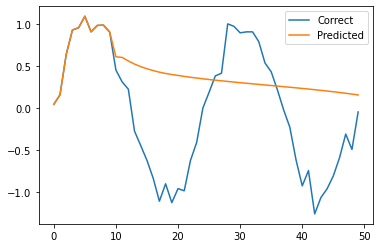

Epoch:11/101 Error:1.210167796298669


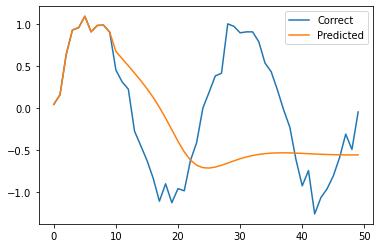

Epoch:21/101 Error:0.6555289548494201


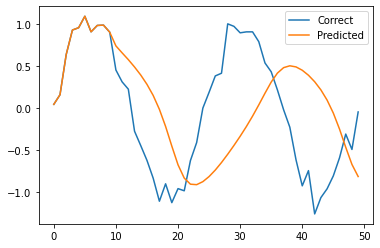

Epoch:31/101 Error:0.5707578842375683


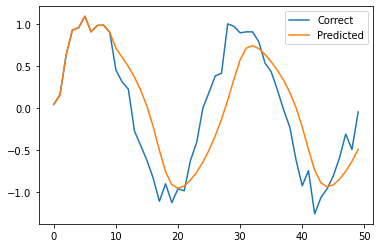

Epoch:41/101 Error:0.5564851948679218


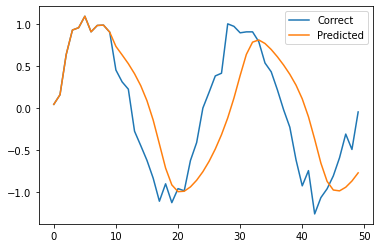

Epoch:51/101 Error:0.551243617398036


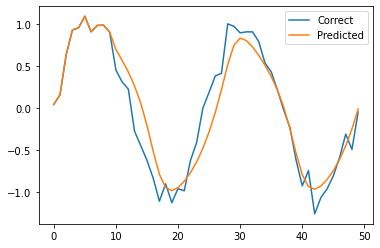

Epoch:61/101 Error:0.5471535308251451


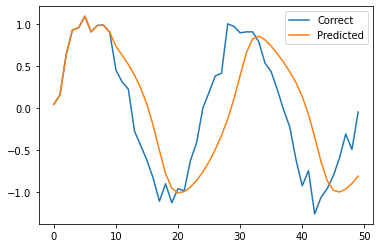

Epoch:71/101 Error:0.550854294725367


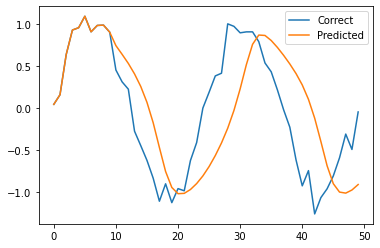

Epoch:81/101 Error:0.5377782737819352


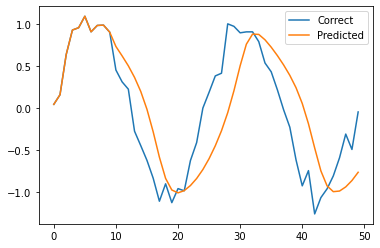

Epoch:91/101 Error:0.5293209645757736


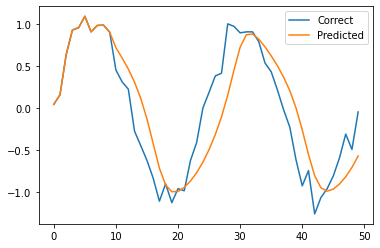

Epoch:101/101 Error:0.5247010361820394


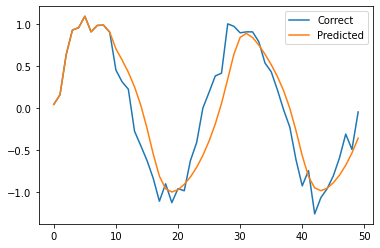

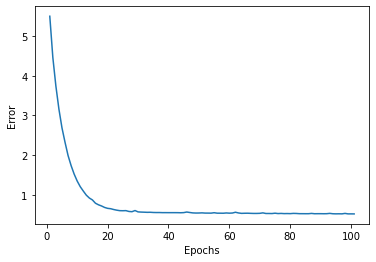

In [54]:
import numpy as np
#import cupy as np
import matplotlib.pyplot as plt

# -- 각 설정값 --
n_time = 10        # 시계열 데이터의 개수
n_in = 1           # 입력층의 뉴런 수
n_mid = 20         # 은닉층의 뉴런 수
n_out = 1          # 출력층의 뉴런 수

eta = 0.01         # 학습률
epochs = 101
batch_size = 8
interval = 10      # 학습 결과 표시 간격

def sigmoid(x):
    return 1/(1+np.exp(-x))

# def sigmoid(x):
#     if x>=0:      #Optimization of the sigmoid function to avoid a huge data overflow
#         return 1.0/(1+exp(-x))
#     else:
#         return exp(x)/(1+exp(x))

# def sigmoid(x):
#     l=len(x)
#     y=[]
#     for i in range(l):
#         if x[i]>=0:
#             y.append(1.0/(1+np.exp(-x[i])))
#         else:
#             y.append(np.exp(x[i])/(np.exp(x[i])+1))
#     return y


# -- 훈련 데이터 생성 --
sin_x = np.linspace(-2*np.pi, 2*np.pi)

# sin 함수에 난수 기반 노이즈 추가
sin_y = np.sin(sin_x) + 0.1*np.random.randn(len(sin_x))

n_sample = len(sin_x)-n_time           # 샘플 개수
input_data = np.zeros((n_sample, n_time, n_in))    # 입력
correct_data = np.zeros((n_sample, n_out))         # 정답
for i in range(0, n_sample):
    input_data[i] = sin_y[i:i+n_time].reshape(-1,1)
    correct_data[i] = sin_y[i+n_time: i+n_time+1]  # 정답은 입력보다 1개 뒤

# -- GRU층 --
# a0: 업데이트 게이트, a1: 리셋 게이트, a2: 새로운 기억
# x: 입력, y_prev: 이전 시점의 출력, grad_y: 출력의 기울기
# w, v: 가중치(행렬 3개를 포함한 배열), n_upper: 앞 신경망층의 뉴런 수
# n: 해당 신경망 층의 뉴런 수
class GRULayer:
    def __init__(self, n_upper, n):
        # 파라미터의 초깃값
        self.w = np.random.randn(3, n_upper, n) / np.sqrt(n_upper)
        self.v = np.random.randn(3, n, n) / np.sqrt(n)
        
    def forward(self, x, y_prev):
        a0 = sigmoid(np.dot(x, self.w[0]) + np.dot(y_prev, self.v[0]))     # 업데이트 게이트
        a1 = sigmoid(np.dot(x, self.w[1]) + np.dot(y_prev, self.v[1]))     # 재설정 게이트
        a2 = np.tanh(np.dot(x, self.w[2]) + np.dot(a1*y_prev, self.v[2]))  # 새로운 기억
        self.gates = np.stack((a0, a1, a2))
        
        self.y = (1-a0)*y_prev + a0*a2     # 출력
        
    def backward(self, x, y, y_prev, gates, grad_y):
        a0, a1, a2 = gates
        
        # 새로운 기억
        delta_a2 = grad_y * a0 * (1-a2**2)
        self.grad_w[2] += np.dot(x.T, delta_a2)
        self.grad_v[2] += np.dot((a1*y_prev).T, delta_a2)
        
        # 업데이트 게이트
        delta_a0 = grad_y * (a2-y_prev) * a0 * (1-a0)
        self.grad_w[0] += np.dot(x.T, delta_a0)
        self.grad_v[0] += np.dot(y_prev.T, delta_a0)
        
        # 리셋 게이트
        s = np.dot(delta_a2, self.v[2].T)
        delta_a1 = s * y_prev * a1 * (1-a1)
        self.grad_w[1] += np.dot(x.T, delta_a1)
        self.grad_v[1] += np.dot(y_prev.T, delta_a1)
        
        # x의 기울기
        self.grad_x = np.dot(delta_a0, self.w[0].T) 
        + np.dot(delta_a1, self.w[1].T) 
        + np.dot(delta_a2, self.w[2].T)
        
        # y_prev 기울기
        self.grad_y_prev = np.dot(delta_a0, self.v[0].T)
        + np.dot(delta_a1, self.v[1].T)
        + a1*s + grad_y*(1-a0)
        
    def reset_sum_grad(self):
        self.grad_w = np.zeros_like(self.w)
        self.grad_v = np.zeros_like(self.v)
        
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.v -= eta * self.grad_v
        
# -- 전결합 출력층 --
class OutputLayer:
    def __init__(self, n_upper, n):
        # 자비에르 초기화(Xavier Initialization) 기반의 초깃값
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = u      # 항등 함수
        
    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
        
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b
        
# -- 각 신경망층의 초기화 --
gru_layer = GRULayer(n_in, n_mid)
output_layer = OutputLayer(n_mid, n_out)

# -- 훈련 --
def train(x_mb, t_mb):
    # 순전파 GRU층
    y_rnn = np.zeros((len(x_mb), n_time+1, n_mid))
    gates_rnn = np.zeros((3, len(x_mb), n_time, n_mid))
    y_prev = y_rnn[:, 0, :]
    for i in range(n_time):
        x = x_mb[:, i, :]
        gru_layer.forward(x, y_prev)
        
        y = gru_layer.y
        y_rnn[:, i+1, :] = y
        y_prev = y
        
        gates = gru_layer.gates
        gates_rnn[:,:,i,:] = gates
        
    # 순전파 출력층
    output_layer.forward(y)
    
    # 역전파 출력층
    output_layer.backward(t_mb)
    grad_y = output_layer.grad_x
#     print(grad_y)
    
    # 역전파 GRU층
    gru_layer.reset_sum_grad()
    for i in reversed(range(n_time)):
        x = x_mb[:, i, :]
        y = y_rnn[:,i+1,:]
        y_prev = y_rnn[:, i, :]
        gates = gates_rnn[:,:,i,:]
        
        gru_layer.backward(x, y, y_prev, gates, grad_y)
        grad_y = gru_layer.grad_y_prev
        
    # 파라미터 갱신
    gru_layer.update(eta)
    output_layer.update(eta)
    
# -- 예측 --
def predict(x_mb):
    # 순전파 GRU층
    y_prev = np.zeros((len(x_mb), n_mid))
    for i in range(n_time):
        x = x_mb[:, i, :]
        gru_layer.forward(x, y_prev)
        y = gru_layer.y
        y_prev = y
        
    # 순전파 출력층
    output_layer.forward(y)
    return output_layer.y

# -- 오차 계산 --
def get_error(x, t):
    y = predict(x)
    return 1.0/2.0*np.sum(np.square(y - t))    # 오차 제곱의 합

error_record = []
n_batch = len(input_data) // batch_size         # 1에포크당 배치 개수

for i in range(epochs):
    # -- 학습 --
    index_random = np.arange(len(input_data))
    np.random.shuffle(index_random)             # 인덱스 뒤섞기(셔플하기)
    for j in range(n_batch):
        # 미니 배치 학습 실행
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x_mb = input_data[mb_index, :]
        t_mb = correct_data[mb_index, :]
        
        train(x_mb, t_mb)
        
    # -- 오차 계산 --
    error = get_error(input_data, correct_data)
    error_record.append(error)
    
    # -- 결과 확인 --
    if i%interval == 0:
        print("Epoch:" + str(i+1)+"/"+str(epochs), "Error:"+str(error))
        
        # 첫 번째 입력
        predicted = input_data[0].reshape(-1).tolist()
        for i in range(n_sample):
            x = np.array(predicted[-n_time:]).reshape(1, n_time, 1)
            y = predict(x)
            
            # 출력을 predicted에 추가
            predicted.append(float(y[0,0]))
            
        plt.plot(range(len(sin_y)), sin_y.tolist(), label="Correct")
        plt.plot(range(len(predicted)), predicted, label="Predicted")
        plt.legend()
        plt.show()

plt.plot(range(1, len(error_record)+1), error_record)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()